In [36]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
df=pd.read_csv("./q_data_x.csv")

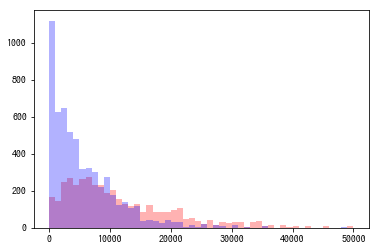

In [38]:
#処置群と対象群のhistgram
plt.hist(df.query("cm_dummy==1")["TVwatch_day"], bins=50, alpha=0.3, histtype='stepfilled', color='r',range=(0,50000))
plt.hist(df.query("cm_dummy==0")["TVwatch_day"], bins=50, alpha=0.3, histtype='stepfilled', color='b',range=(0,50000))
plt.show()

In [39]:
#CM視聴者のTV視聴時間
print(df.query("cm_dummy==1")["gamesecond"].mean())
print(df.query("cm_dummy==0")["gamesecond"].mean())
df.query("cm_dummy==1")["gamesecond"].mean()-df.query("cm_dummy==0")["gamesecond"].mean()

2478.0658783783783
3107.7064549180327


-629.6405765396544

TVを見ないほうが600秒近くゲームをする時間が長い

In [40]:
#傾向スコアを出すための準備
#（ここの決め方が実は難しいのでは？）
X = df.drop(['cm_dummy', 'gamedummy','gamesecond', 'gamecount',"area_keihan", \
             'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3',"job_dummy8","fam_str_dummy5"],axis=1)
X['intercept'] = 1
y = df["cm_dummy"]

In [41]:
#ロジスティック回帰
#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression()
#lr.fit(X, y)
#ps=lr.predict_proba(X)
#ps=ps[:,1]

In [42]:
import statsmodels.api as sm
lr = sm.Logit(y, X)
result = lr.fit()
ps=result.predict(X)

Optimization terminated successfully.
         Current function value: 0.542117
         Iterations 6


In [44]:
#傾向スコアの当てはまり確認
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            No. Iterations:   6.0000    
Dependent Variable: cm_dummy         Pseudo R-squared: 0.201     
Date:               2018-10-31 16:16 AIC:              10886.3417
No. Observations:   10000            BIC:              11044.9692
Df Model:           21               Log-Likelihood:   -5421.2   
Df Residuals:       9978             LL-Null:          -6784.2   
Converged:          1.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
area_kanto        0.4050   0.0790   5.1239 0.0000  0.2501  0.5599
area_tokai       -0.7233   0.0765  -9.4490 0.0000 -0.8733 -0.5732
area_keihanshin  -2.0420   0.0756 -27.0074 0.0000 -2.1902 -1.8938
age              -0.0026   0.0029  -0.8871 0.3750 -0.0084  0.0032
sex               0.0006   0.0647   0.0092 0.9927 -0.1262  0.1273
marry_dummy      -0.0781   0.0856  -0.9134 0.3610 -0.2458  0.0895
job_dummy1        0.1752   0.1562   1.1219 0.2619 -0.1309  0.4814
job_dummy2        0.1651   0.1677   0.9842 0.3250 -0.1637  0.4938
job_dummy3        0.5399   0.1604   3.3659 0.0008  0.2255  0.8543
job_dummy4        0.3604   0.2433   1.4811 0.1386 -0.1165  0.8372
job_dummy5        0.6414   0.1520   4.2193 0.0000  0.3435  0.9393
job_dummy6        0.2848   0.1581   1.8010 0.0717 -0.0251  0.5947
job_dummy7        0.1540   0.1834   0.8394 0.4013 -0.2056  0.5135
inc              -0.0005   0.0002  -2.9190 0.0035 -0.0008 -0.0002
pmoney            0.0119   0.0077   1.5434 0.1227 -0.0032  0.0271
fam_str_dummy1    0.7640   0.2045   3.7359 0.0002  0.3632  1.1648
fam_str_dummy2    1.0033   0.2176   4.6118 0.0000  0.5769  1.4297
fam_str_dummy3    0.6137   0.2021   3.0373 0.0024  0.2177  1.0098
fam_str_dummy4    0.1799   0.2216   0.8121 0.4167 -0.2543  0.6142
child_dummy       0.3142   0.0743   4.2269 0.0000  0.1685  0.4599
TVwatch_day       0.0001   0.0000  31.9917 0.0000  0.0001  0.0001
intercept        -1.7709   0.2615  -6.7728 0.0000 -2.2833 -1.2584
=================================================================

"""

In [45]:
from sklearn import metrics
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y, ps)
# ついでにAUCも
auc = metrics.auc(fpr, tpr)
auc

0.7917028470947529

In [46]:
#層別マッチング(0.05刻み)
interval = np.arange(0,1.05,0.05)
match_list = []
table=df[["cm_dummy","gamesecond"]]
table["ps"]=ps
for i in range(0,len(interval)-1):
    temp0 = table[(table['cm_dummy']==0) & (interval[i] < table['ps']) & (table['ps'] < interval[i+1])]
    temp1 = table[(table['cm_dummy']==1) & (interval[i] < table['ps']) & (table['ps'] < interval[i+1])]
    if (len(temp0) > 0) & (len(temp1) > 0):
        match_list.append(temp1['gamesecond'].mean()-temp0['gamesecond'].mean())

np.mean(match_list)

/home/mizutani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


611.4672067284943

In [47]:
#重み付け推定法
z1=df["cm_dummy"]
y=df["gamesecond"]

ipwe1 = sum((z1*y)/ps)/sum(z1/ps)
ipwe0 = sum(((1-z1)*y)/(1-ps))/sum((1-z1)/(1-ps))
print(ipwe1)
print(ipwe0)
ipwe1 - ipwe0

4143.330591058508
2639.412134742171


1503.9184563163367

In [48]:
#weightをつけて線形回帰を再実施
df["ps"]=ps
X=df.query("cm_dummy==1")[['area_kanto','area_tokai',
       'area_keihanshin', 'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2']]
X["intercept"]=1
y=df.query("cm_dummy==1")["gamesecond"]
weight=df.query("cm_dummy==1")["ps"]
import statsmodels.api as sm
mod_wls = sm.WLS(y, X, weights=1/weight)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:             gamesecond   R-squared:                       0.076
Model:                            WLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     33.93
Date:                Wed, 31 Oct 2018   Prob (F-statistic):           4.09e-64
Time:                        16:17:19   Log-Likelihood:                -47174.
No. Observations:                4144   AIC:                         9.437e+04
Df Residuals:                    4133   BIC:                         9.444e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
area_kanto      -2729.1755   1083.672     

In [49]:
df["ps"]=ps
X=df.query("cm_dummy==0")[['area_kanto','area_tokai',
       'area_keihanshin', 'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2']]
X["intercept"]=1
y=df.query("cm_dummy==0")["gamesecond"]
weight=df.query("cm_dummy==0")["ps"]
import statsmodels.api as sm
mod_wls = sm.WLS(y, X, weights=1/(1-weight))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:             gamesecond   R-squared:                       0.019
Model:                            WLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.19
Date:                Wed, 31 Oct 2018   Prob (F-statistic):           3.55e-19
Time:                        16:17:22   Log-Likelihood:                -66030.
No. Observations:                5856   AIC:                         1.321e+05
Df Residuals:                    5845   BIC:                         1.322e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
area_kanto        -28.2667    846.665     

child_dummyはCM接触の有無にほとんど影響しない
（説明変数変えると値が結構変わるけど）